In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, accuracy_score)
from sklearn.cluster import KMeans
import warnings

from IPython.display import Markdown

warnings.filterwarnings('ignore')

#visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

display(Markdown("**VARIABLE IMPORTANCE ANALYSIS**"))
display(Markdown(
    "Identifying which variables best predict customer churn and "
    "build models to identify at risk customers before they leave"
))


**VARIABLE IMPORTANCE ANALYSIS**

Identifying which variables best predict customer churn and build models to identify at risk customers before they leave

In [7]:
df = pd.read_csv('BankChurners.csv')

print(f" Dataset loaded successfully!")
print(f"   Total customers: {len(df):,}")
print(f"   Total features: {len(df.columns)}")

# Create binary churn variable
df['Churn'] = (df['Attrition_Flag'] == 'Attrited Customer').astype(int)

churn_count = df['Churn'].sum()
churn_rate = (churn_count / len(df)) * 100

print(f"\n Churn Overview:")
print(f"   Churned customers: {churn_count:,} ({churn_rate:.2f}%)")
print(f"   Retained customers: {len(df) - churn_count:,} ({100-churn_rate:.2f}%)")

 Dataset loaded successfully!
   Total customers: 10,127
   Total features: 23

 Churn Overview:
   Churned customers: 1,627 (16.07%)
   Retained customers: 8,500 (83.93%)


In [72]:
# Analyzing correlation of all variables with churn
display(Markdown("**VARIABLE CORRELATION ANALYSIS**"))

# All numerical variables
numerical_vars = ['Customer_Age', 'Dependent_count', 'Months_on_book',
                  'Total_Relationship_Count', 'Months_Inactive_12_mon',
                  'Contacts_Count_12_mon', 'Credit_Limit', 
                  'Total_Revolving_Bal', 'Avg_Open_To_Buy',
                  'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 
                  'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
                  'Avg_Utilization_Ratio', 'Churn']

# Correlations
correlation = df[numerical_vars].corr()['Churn'].sort_values(ascending=False)

display(Markdown(
    "Correlation with Churn (sorted by strength):"
))

print(f"{'Variable':<30} {'Correlation':<15} {'Strength'}")
print("-" * 80)

for var, corr in correlation.items():
    if var != 'Churn':
        # Determining strength
        abs_corr = abs(corr)
        if abs_corr > 0.3:
            strength = "⭐ STRONG"
        elif abs_corr > 0.1:
            strength = "✅ MODERATE"
        else:
            strength = "⚠️  WEAK"
        
        print(f"{var:<30} {corr:>+.4f}          {strength}")

print("\n")

# Identifying top predictors
top_predictors = correlation.drop('Churn').abs().nlargest(5)
display(Markdown("\n TOP 5 CHURN PREDICTORS:"))
for i, (var, corr) in enumerate(top_predictors.items(), 1):
    print(f"   {i}. {var}: {correlation[var]:+.4f}")

**VARIABLE CORRELATION ANALYSIS**

Correlation with Churn (sorted by strength):

Variable                       Correlation     Strength
--------------------------------------------------------------------------------
Contacts_Count_12_mon          +0.2045          ✅ MODERATE
Months_Inactive_12_mon         +0.1524          ✅ MODERATE
Dependent_count                +0.0190          ⚠️  WEAK
Customer_Age                   +0.0182          ⚠️  WEAK
Months_on_book                 +0.0137          ⚠️  WEAK
Avg_Open_To_Buy                -0.0003          ⚠️  WEAK
Credit_Limit                   -0.0239          ⚠️  WEAK
Total_Amt_Chng_Q4_Q1           -0.1311          ✅ MODERATE
Total_Relationship_Count       -0.1500          ✅ MODERATE
Total_Trans_Amt                -0.1686          ✅ MODERATE
Avg_Utilization_Ratio          -0.1784          ✅ MODERATE
Total_Revolving_Bal            -0.2631          ✅ MODERATE
Total_Ct_Chng_Q4_Q1            -0.2901          ✅ MODERATE
Total_Trans_Ct                 -0.3714          ⭐ STRONG





 TOP 5 CHURN PREDICTORS:

   1. Total_Trans_Ct: -0.3714
   2. Total_Ct_Chng_Q4_Q1: -0.2901
   3. Total_Revolving_Bal: -0.2631
   4. Contacts_Count_12_mon: +0.2045
   5. Avg_Utilization_Ratio: -0.1784



 **GENERATING CORRELATION HEATMAP**

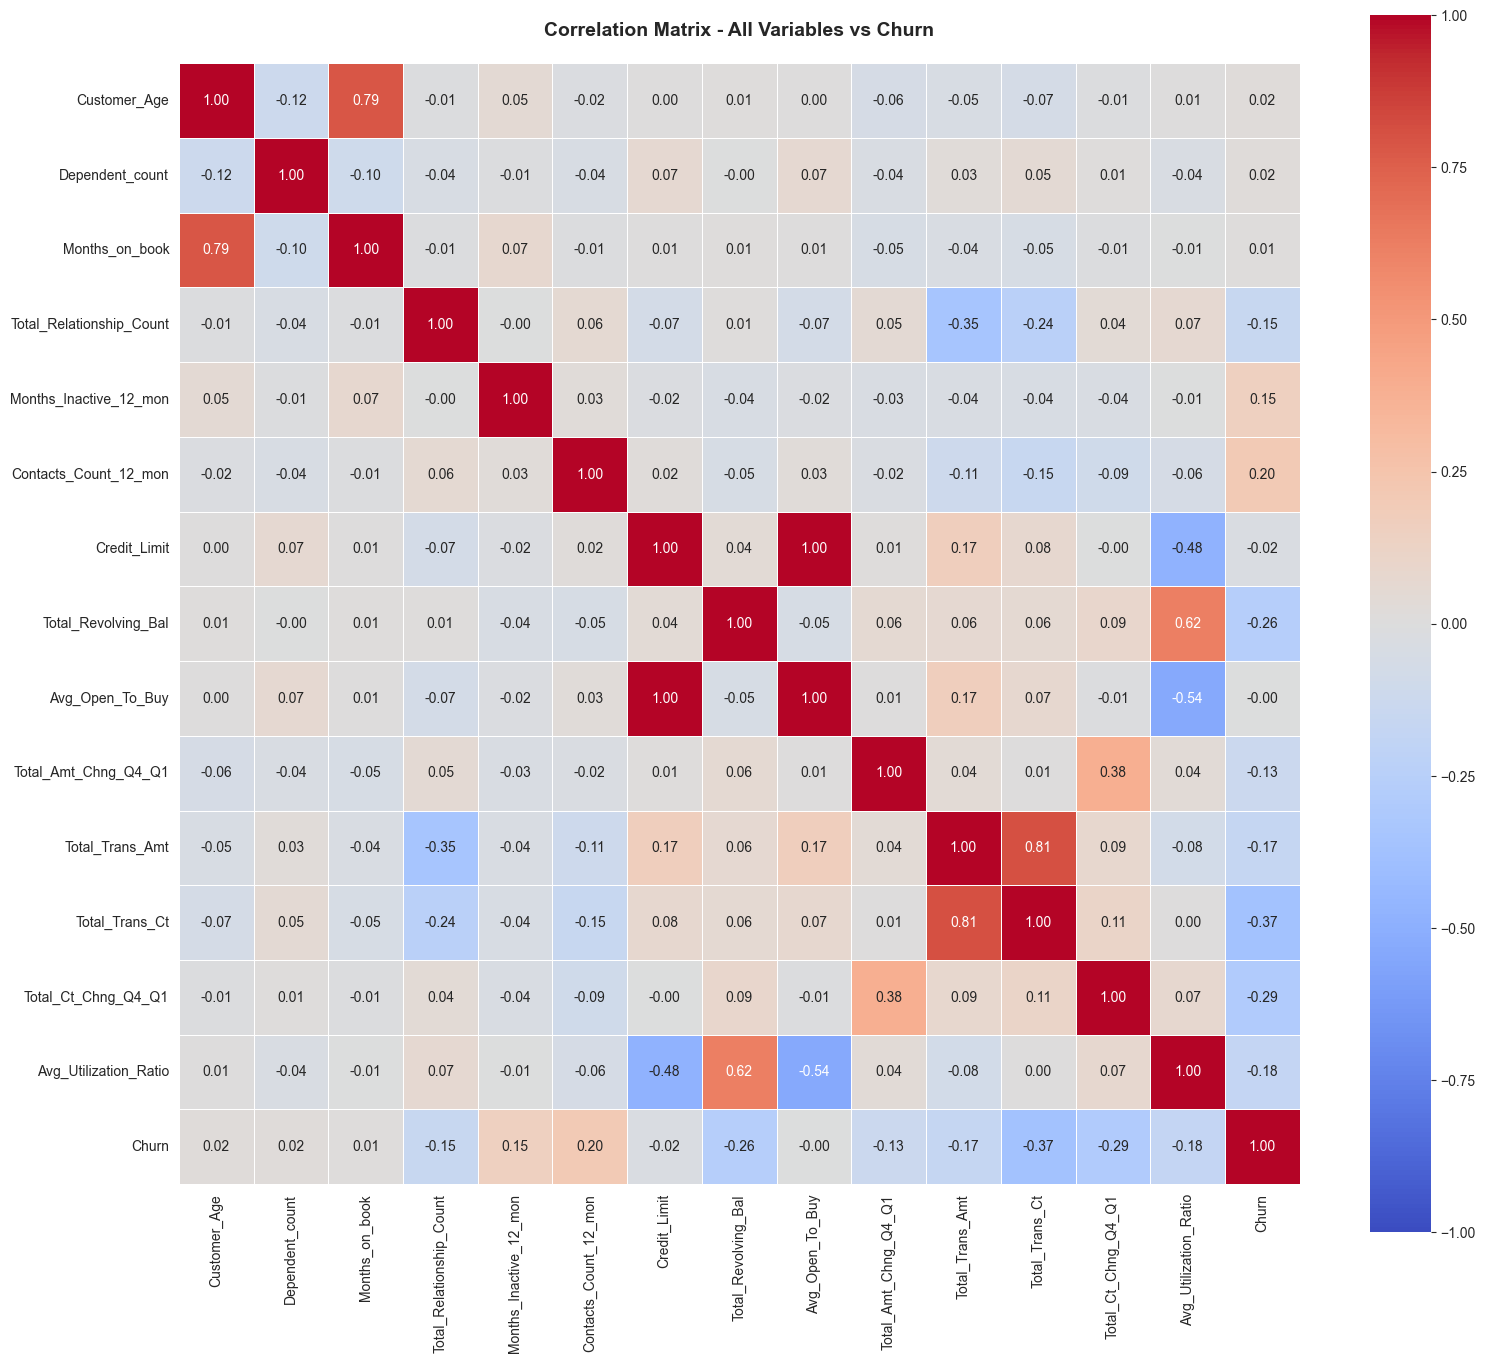


 **Reading Guid:**

   Red = Strong positive correlation (as one ↑, other ↑)

   Blue = Strong negative correlation (as one ↑, other ↓)

   White = No correlation

In [71]:
display(Markdown("\n **GENERATING CORRELATION HEATMAP**"))

plt.figure(figsize=(16, 16))

# Full correlation matrix
corr_matrix = df[numerical_vars].corr()

# Heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            center=0, vmin=-1, vmax=1)

plt.title('Correlation Matrix - All Variables vs Churn', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

#Reading guid
display(Markdown("\n **Reading Guid:**"))
display(Markdown("   Red = Strong positive correlation (as one ↑, other ↑)"))
display(Markdown("   Blue = Strong negative correlation (as one ↑, other ↓)"))
display(Markdown("   White = No correlation"))


 **TOP CHURN PREDICTORS** 



 The box plots show the distribution of each variable for churned vs existing customers

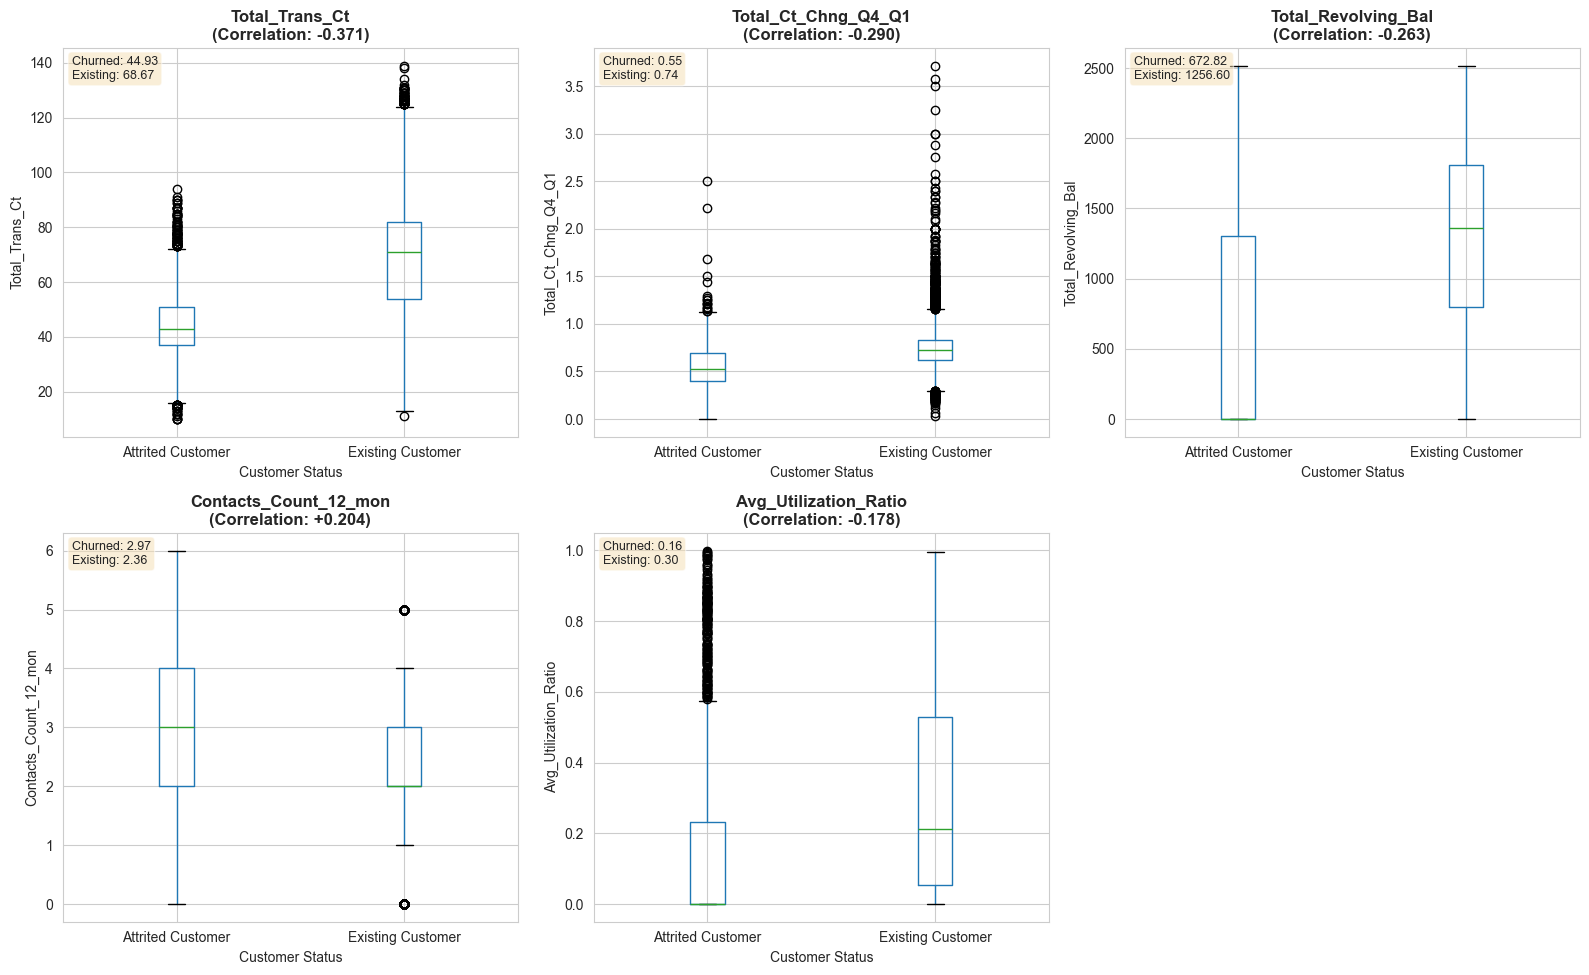

In [70]:
# Top predictors
display(Markdown("\n **TOP CHURN PREDICTORS** \n"))

display(Markdown("\n The box plots show the distribution of each variable for churned vs existing customers"))

print("\n")

top_5_vars = correlation.drop('Churn').abs().nlargest(5).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, var in enumerate(top_5_vars):
    # Box plot
    df.boxplot(column=var, by='Attrition_Flag', ax=axes[idx])
    axes[idx].set_title(f'{var}\n(Correlation: {correlation[var]:+.3f})', 
                        fontweight='bold')
    axes[idx].set_xlabel('Customer Status')
    axes[idx].set_ylabel(var)
    axes[idx].get_figure().suptitle('')
    
    # Calculate means
    churned_mean = df[df['Churn']==1][var].mean()
    existing_mean = df[df['Churn']==0][var].mean()
    
    # Add statistics
    stats_text = f"Churned: {churned_mean:.2f}\nExisting: {existing_mean:.2f}"
    axes[idx].text(0.02, 0.98, stats_text, transform=axes[idx].transAxes,
                   verticalalignment='top', bbox=dict(boxstyle='round', 
                   facecolor='wheat', alpha=0.5), fontsize=9)

# Remove extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()
